In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.linalg
import analytical_solution as anso

In [2]:
#### INPUT PARAMETERS ####
N = 1000
omega = 1
L = 5
k = 14

In [3]:
#### VARIABLES NEEDED TO BE COMPUTED ####
deltax = (2*L)/N
x_i = np.array([(((2*L)/N)*i - L) for i in range(N)])

## Functions

In [14]:
def kinetic_gen(size, deltax, order = 2):
    factor = 1/(2*(deltax**2))

    if (order == 2):
        main_diag = 2 * np.ones(size)
        off_diag = -1 * np.ones(size - 1)

        K = factor * (np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1))
    elif (order == 4):
        main_diag = (5 / 2) * np.ones(size)  # Main diagonal
        first_off_diag = (-4 / 3) * np.ones(size - 1)  # First off-diagonals
        second_off_diag = (1 / 12) * np.ones(size - 2)  # Second off-diagonals

        K = factor * (
            np.diag(main_diag) + np.diag(first_off_diag, k=1) + np.diag(first_off_diag, k=-1) +  
            np.diag(second_off_diag, k=2) + np.diag(second_off_diag, k=-2)   
        )

    # elif (order == 6):

    else:
        print("Invalid order value. It must be either 2, 4 or 6.")
    return K

def potential_gen(size, x_i, omega):
    factor = (omega**2)/2
    main_diag = (x_i**2) * np.ones(size)

    V = factor * np.diag(main_diag)

    return V

def hamiltonian_gen(size, deltax, x_i, omega, order = 2):

    K = kinetic_gen(size, deltax, order)
    V = potential_gen(size, x_i, omega)

    A = K + V

    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)  # Get indices of sorted eigenvalues
    eigenvalues = eigenvalues[sorted_indices]  # Sort eigenvalues
    eigenvectors = eigenvectors[:, sorted_indices]  # Sort eigenvectors to match eigenvalues

    # Select the first k eigenvalues and corresponding eigenvectors
    norm = np.sqrt(np.sum(np.abs(eigenvectors)**2, axis=0))
    for i in range(len(eigenvalues)):
        eigenvectors[:, i] = eigenvectors[:, i] / norm

    center_index = N // 2  # assuming symmetric grid centered around x = 0

    for i in range(len(eigenvectors)):
        if i % 2 == 0:  # Even states
            # Ensure the wavefunction is positive at the center
            if ((i//2)%2==0 and eigenvectors[:, i][center_index] < 0) or ((i//2)%2!=0 and eigenvectors[:, i][center_index] > 0):
                eigenvectors[:, i] *= -1
        else:  # Odd states
            # Find the first peak after the center and make it positive
            first_peak_index = center_index + np.argmax(np.abs(eigenvectors[i][center_index:]))
            if eigenvectors[:, i][first_peak_index] < 0:
                eigenvectors[:, i] *= -1
    
    return A, eigenvalues, eigenvectors.T

def plot(k, eigenvalues, eigenvectors):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    colors = plt.cm.tab20.colors[:k]
    
    for i in range(k):
      ax1.plot(x_i, eigenvectors[i], label=f"{i}-th eigenvector $\psi(x)$", color=colors[i], linewidth=1.5, linestyle="--")

    ax1.set_xlabel("Position $x$")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Wavefunctions of Quantum Harmonic Oscillator")
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax1.set_xlim(-L,L)

    # Plot the potential and energy levels in the second subplot
    ax2.plot(x_i, 0.5 * omega**2 * x_i**2, label="Harmonic potential $V(x)$", color="red", linestyle="--", linewidth=1.5)
    for i in range(k):
      ax2.axhline(eigenvalues[i], label=f"{i}-th eigenvelue", color=colors[i], linestyle="-.", linewidth=1, alpha=0.8)

    ax2.set_xlabel("Position $x$")
    ax2.set_ylabel("Energy")
    ax2.set_title("Energy Levels and Harmonic Potential")
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax2.set_xlim(-L,L)

    fig.tight_layout()
    plt.show()

## Analytical

In [15]:
eigenvalues_analy = []
eigenvectors_analy = []

for i in range(k):
    wavefunction = anso.harmonic_wfc(x_i, omega, i)
    
    norm = np.sqrt(np.sum(np.abs(wavefunction)**2))
    eigenvector = wavefunction / norm
    
    eigenvalue = anso.harmonic_en(omega, i)
    
    eigenvalues_analy.append(eigenvalue)
    eigenvectors_analy.append(eigenvector)

eigenvalues_analy = np.array(eigenvalues_analy)
eigenvectors_analy = np.array(eigenvectors_analy)

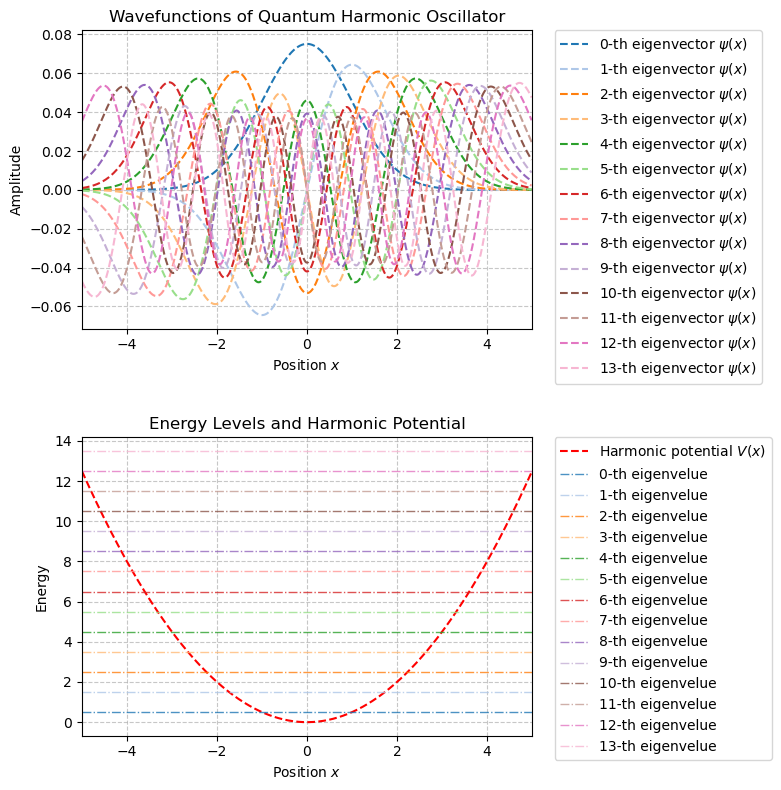

In [16]:
plot(k, eigenvalues_analy, eigenvectors_analy)

## Order 2

In [17]:
order = 2
A, eigenvalues_order2, eigenvectors_order2 = hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order2 = eigenvalues_order2[:k]
eigenvectors_order2 = eigenvectors_order2[:k]

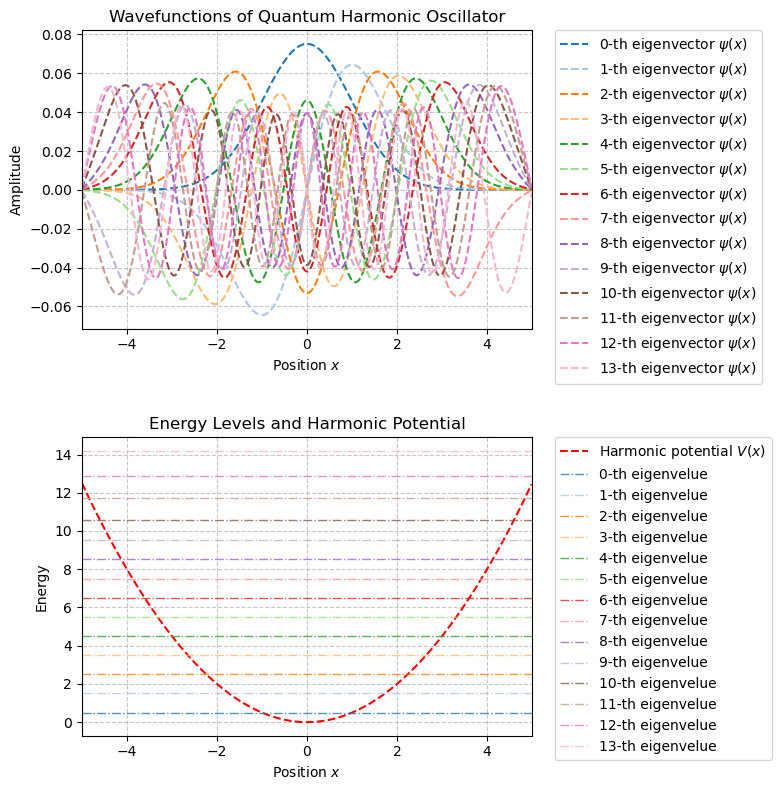

In [18]:
plot(k, eigenvalues_order2, eigenvectors_order2)

## Order 4

In [19]:
order = 4
A, eigenvalues_order4, eigenvectors_order4 = hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order4 = eigenvalues_order4[:k]
eigenvectors_order4 = eigenvectors_order4[:k]

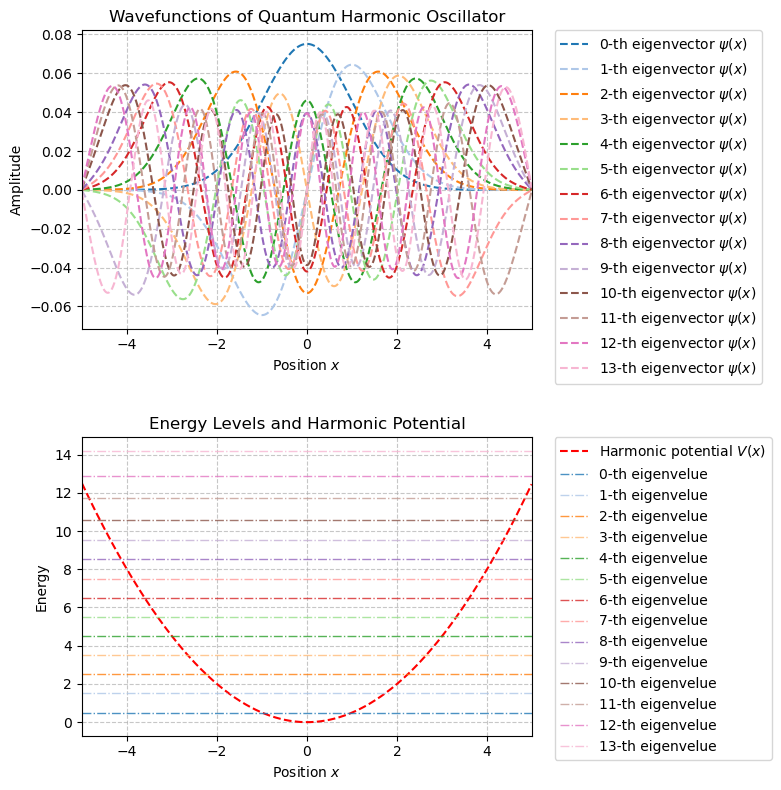

In [20]:
plot(k, eigenvalues_order4, eigenvectors_order4)

## Correctness

In [28]:
def correctness(k, eigenvalues, eigenvectors, eigenvalues_analy, eigenvectors_analy):
    # Eigenvalue errors
    eigval_errors = np.abs(eigenvalues - eigenvalues_analy)
    relative_eigval_errors = eigval_errors / np.abs(eigenvalues_analy)

    # Eigenvector errors
    eigvec_angles = []
    for i in range(k):
        # Normalize both eigenvectors
        vec_approx = eigenvectors[i] / np.linalg.norm(eigenvectors[i])
        vec_analytical = eigenvectors_analy[i] / np.linalg.norm(eigenvectors_analy[i])

        # Calculate the cosine similarity
        cos_theta = np.dot(vec_approx, vec_analytical)
        # theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical errors

        # # Store the angle in degrees for better interpretability
        # eigvec_angles.append(np.degrees(theta))
        eigvec_angles.append(1 - np.abs(cos_theta))

    # Output results
    print("Eigenvalue Errors:", eigval_errors)
    print("Relative Eigenvalue Errors:", relative_eigval_errors)
    print("Eigenvector Angles (in degrees):", eigvec_angles)

    return eigval_errors, relative_eigval_errors, eigvec_angles

def plot_correctness(rel_eigval_err, eigvec_angles):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot 1: Eigenvalue Errors
    axes[0].bar(range(1, k + 1), rel_eigval_err, color='teal', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel("Eigenvalue Index", fontsize=12)
    axes[0].set_ylabel("Relative Error", fontsize=12)
    axes[0].set_title("Relative Error in Eigenvalues", fontsize=14)
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # Plot 2: Eigenvector Angles
    axes[1].bar(range(1, k + 1), eigvec_angles, color='orange', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel("Eigenvector Index", fontsize=12)
    axes[1].set_ylabel("Angle (Degrees)", fontsize=12)
    axes[1].set_title("Angle Between Approximate and Analytical Eigenvectors", fontsize=14)
    axes[1].grid(True, linestyle="--", alpha=0.5)

    # Display the plots
    plt.tight_layout()
    plt.show()

I first consider the correctness w.r.t. the order 2 

Eigenvalue Errors: [3.12494626e-06 1.56216652e-05 4.05452141e-05 7.69546371e-05
 1.15975959e-04 9.54779456e-05 3.16467358e-04 2.48455965e-03
 1.06997448e-02 3.51124003e-02 9.34638545e-02 2.08424479e-01
 4.01209010e-01 6.86545064e-01]
Relative Eigenvalue Errors: [6.24989253e-06 1.04144435e-05 1.62180856e-05 2.19870392e-05
 2.57724353e-05 1.73596265e-05 4.86872859e-05 3.31274620e-04
 1.25879350e-03 3.69604213e-03 8.90131948e-03 1.81238678e-02
 3.20967208e-02 5.08551899e-02]
Eigenvector Angles (in degrees): [1.1336376282145011e-11, 1.2564882467813732e-10, 1.3716471292113397e-09, 1.800118909489612e-08, 2.0597320304904798e-07, 1.8963230651314333e-06, 1.4277600823842107e-05, 8.9844001580075e-05, 0.0004733193264297997, 0.002047654769980145, 0.007146166753624117, 0.02026060284826381, 0.048245125584005066, 0.10090755619089598]


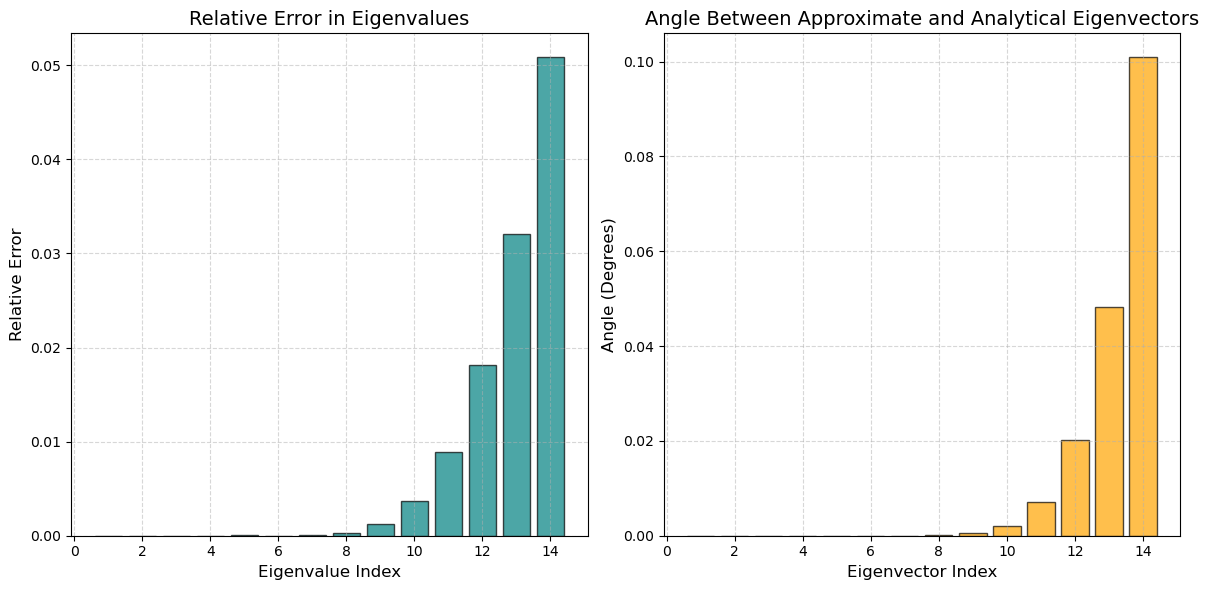

In [29]:
eigval_err_order2, rel_eigval_err_order2, eigvec_angles_order2 = correctness(k, eigenvalues_order2, eigenvectors_order2, eigenvalues_analy, eigenvectors_analy)

plot_correctness(rel_eigval_err_order2, eigvec_angles_order2)

I then consider the correctness w.r.t. the degree 4

Eigenvalue Errors: [2.80980794e-11 2.80231571e-09 7.83786596e-08 1.17295264e-06
 1.22140314e-05 9.56961775e-05 5.85378307e-04 2.85284809e-03
 1.12079685e-02 3.58374522e-02 9.45283779e-02 2.09984396e-01
 4.03427608e-01 6.89576451e-01]
Relative Eigenvalue Errors: [5.61961588e-11 1.86821048e-09 3.13514638e-08 3.35129327e-07
 2.71422920e-06 1.73993050e-05 9.00582010e-05 3.80379746e-04
 1.31858453e-03 3.77236339e-03 9.00270266e-03 1.82595127e-02
 3.22742086e-02 5.10797371e-02]
Eigenvector Angles (in degrees): [7.718270467194088e-13, 4.0757508479316584e-11, 1.0404833661326052e-09, 1.7119991979619442e-08, 2.0448246906834555e-07, 1.8972659547866755e-06, 1.4307844496852518e-05, 9.010093791517182e-05, 0.0004749515282842509, 0.002055372840773839, 0.007173088268934591, 0.02033245911569681, 0.04840050711423227, 0.10119332767391775]


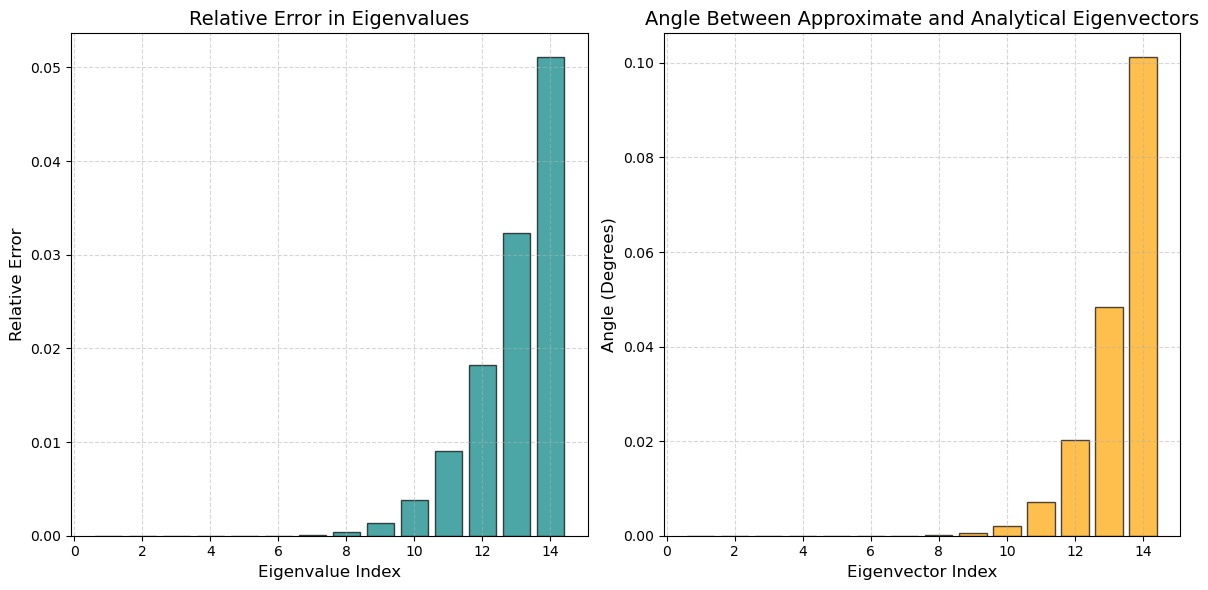

In [30]:
eigval_err_order4, rel_eigval_err_order4, eigvec_angles_order4 = correctness(k, eigenvalues_order4, eigenvectors_order4, eigenvalues_analy, eigenvectors_analy)

plot_correctness(rel_eigval_err_order4, eigvec_angles_order4)